In [65]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import glob
import redditcleaner
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import FreqDist
import emoji
import re
import en_core_web_sm
import spacy
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
from numpy import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Austin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Austin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
import seaborn as sns

In [2]:
#gather all data from csv, prolly really inefficient
current_data = pd.read_csv('./collected_data/combined_csv.csv')

[56000, 54048, 21462, 56000, 56000, 56000, 54000, 54000, 7630, 54000, 34412]


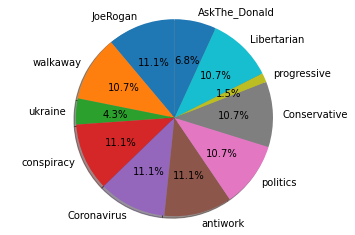

In [3]:
subreddit_list = ["JoeRogan", "walkaway", "ukraine", "conspiracy", "Coronavirus", 
                  "antiwork", "politics", "Conservative", "progressive", "Libertarian", "AskThe_Donald"]

def get_total_comments(df, subreddit_list):
    
    total_comments = []
    
    for sub in subreddit_list:
        x = df.loc[df['subreddit'] == str(sub)]
        total_comments.append(x.shape[0])
    return total_comments
    

    
def create_pie_chart(comments_shape_list, subreddit_list): 
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = subreddit_list
    sizes = comments_shape_list
    explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=None, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
    
x = get_total_comments(current_data, subreddit_list)
print(x)
create_pie_chart(x, subreddit_list)

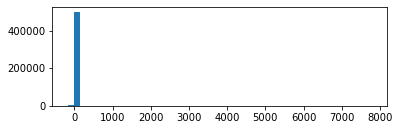

In [4]:
def show_total_updoots(df, subreddit_list):
    
    x = df['score']
    # histogram on linear scale
    plt.subplot(211)
    hist, bins, _ = plt.hist(x, bins=50)

#     # histogram on log scale. 
#     # Use non-equal bin sizes, such that they look equal on log scale.
#     hist, bins = np.histogram(x, bins=10)
#     logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
#     plt.hist(x, bins=logbins)
#     plt.xscale('log')

show_total_updoots(current_data, subreddit_list)
    

In [5]:
def get_upvote_averages_by_subreddit(df, subreddit_list):
    
    list_of_averages = []
    
    #get average upvote per sub
    for sub in subreddit_list:
        curr_sub = df.loc[df['subreddit'] == str(sub)]
        x = curr_sub["score"].mean()
        list_of_averages.append(x)
        
    #get ave of all subs    
    x = df['score'].mean()
    list_of_averages.append(x)
    
    return list_of_averages

def show_average_upvotes_per_sub(list_of_averages, subreddit_list):
    
    # creating the dataset
    subreddit_list.append("all")

    fig = plt.figure(figsize=(15, 7))

    # creating the bar plot
    plt.bar(subreddit_list, list_of_averages, color ='maroon',
            width = 0.4)

    plt.xlabel("Subreddit")
    plt.ylabel("Ave. of Upvotes (score)")
    plt.title("Average Upvotes per Subreddit")
    plt.show()

    
#average upvotes across each sub, over a sample of 10000 comments
sample_data = current_data.sample(10000)
x = get_upvote_averages_by_subreddit(current_data, subreddit_list)
print(x)


[4.010696428571428, 4.726557874481942, 2.7040350386730037, 2.920607142857143, 6.138625, 5.754035714285714, 6.225518518518519, 5.185444444444444, 3.518348623853211, 2.6768703703703705, 2.6047890270835756, 4.458051998601932]


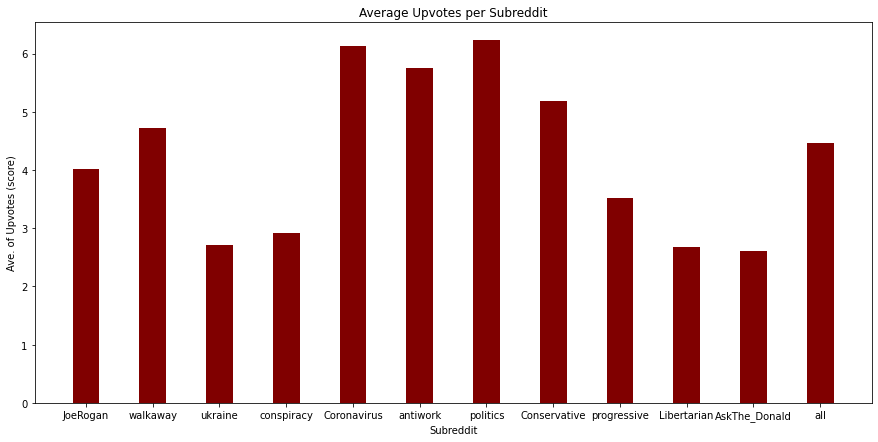

In [6]:
show_average_upvotes_per_sub(x, subreddit_list)

In [7]:
print(current_data['author'].nunique())
current_data.shape

143116


(503552, 13)

In [8]:
#https://www.datacamp.com/community/tutorials/wordcloud-python
def generate_wordcloud(df):
    # Start with one review:
    y = df.body
    text = " ".join(str(word) for word in y)
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

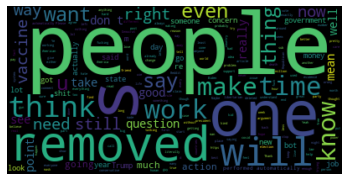

In [9]:
generate_wordcloud(sample_data)


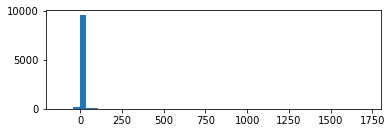

In [10]:
show_total_updoots(sample_data, subreddit_list)

In [11]:
subreddit_list = ["JoeRogan", "walkaway", "ukraine", "conspiracy", "Coronavirus", 
                  "antiwork", "politics", "Conservative", "progressive", "Libertarian", "AskThe_Donald"]


for sub in subreddit_list:
    x = current_data.loc[current_data['subreddit'] == str(sub)]
    print("Sub: ", str(sub), "Unique authors", x['author'].nunique())
    
    

current_data['author'].nunique()

Sub:  JoeRogan Unique authors 18719
Sub:  walkaway Unique authors 9855
Sub:  ukraine Unique authors 3581
Sub:  conspiracy Unique authors 18499
Sub:  Coronavirus Unique authors 20765
Sub:  antiwork Unique authors 21844
Sub:  politics Unique authors 31060
Sub:  Conservative Unique authors 16602
Sub:  progressive Unique authors 1710
Sub:  Libertarian Unique authors 12206
Sub:  AskThe_Donald Unique authors 5458


143116

In [12]:
current_data['author'].nunique()

143116

In [13]:
def clean_data(comments_df):
    remove_author_list = ["[deleted]", "AutoMod", "AutoModerator", "", None]
    remove_body_list = ["u/savevideo", "[removed]"]
    
    #remove all authors with name in the list, ie remove all [deleted]
    comments_df = comments_df[~comments_df.author.isin(remove_author_list)]
    comments_df = comments_df[~comments_df.body.isin(remove_body_list)]
    
    #https://github.com/LoLei/redditcleaner
    #clean body data, remove wierd text and junk, must change all comments to strings first
    comments_df['body'] = comments_df["body"].map(str)

    comments_df['body'] = comments_df['body'].map(redditcleaner.clean)

    return comments_df

In [14]:
big_data = pd.read_csv('./cleaned_dataset.csv', low_memory=False)
big_data.shape



(1196798, 14)

In [15]:
big_data= clean_data(big_data)

big_data.shape


(1127044, 14)

In [16]:
big_data['subreddit'].nunique()

11

In [17]:
subreddit_list_2 = ["JoeRogan", "walkaway", "ukraine", "WorkReform", "Coronavirus", 
                  "antiwork", "politics", "Conservative", "progressive", "Libertarian", "HermanCainAward"]

In [18]:
for sub in subreddit_list_2:
    x = big_data.loc[big_data['subreddit'] == str(sub)]
    print("Sub: ", str(sub), "Unique authors", x['author'].nunique())
    
    

big_data['author'].nunique()

Sub:  JoeRogan Unique authors 19771
Sub:  walkaway Unique authors 5203
Sub:  ukraine Unique authors 915
Sub:  WorkReform Unique authors 19921
Sub:  Coronavirus Unique authors 9457
Sub:  antiwork Unique authors 144249
Sub:  politics Unique authors 103474
Sub:  Conservative Unique authors 199
Sub:  progressive Unique authors 134
Sub:  Libertarian Unique authors 6971
Sub:  HermanCainAward Unique authors 13817


283558

[89985, 17408, 1528, 45946, 24356, 463880, 383805, 317, 174, 42316, 57325]


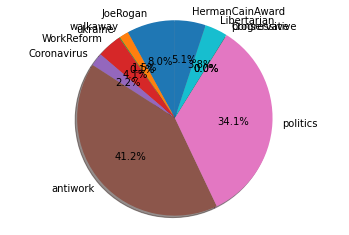

1127040

In [19]:
x = get_total_comments(big_data, subreddit_list_2)
print(x)
create_pie_chart(x, subreddit_list_2)
sum(x)

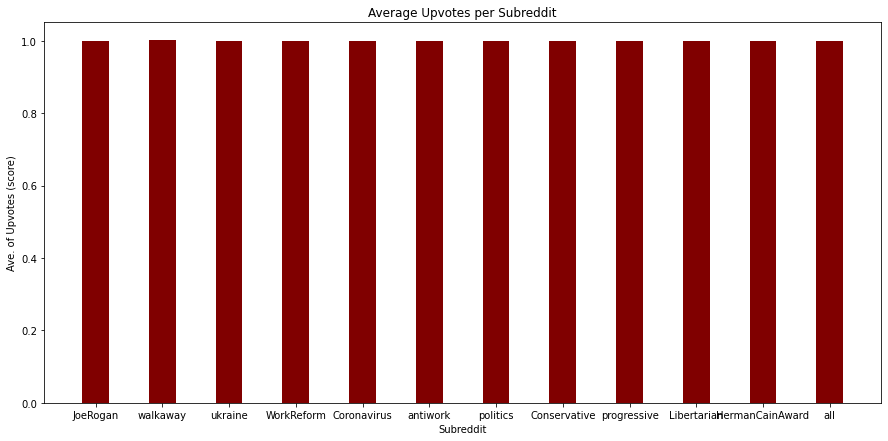

In [20]:
ave = get_upvote_averages_by_subreddit(big_data, subreddit_list_2)
show_average_upvotes_per_sub(ave, subreddit_list_2)

In [21]:
big_data['subreddit'].nunique()

11

In [22]:
#https://stackoverflow.com/questions/57693731/pandas-search-list-of-keywords-in-the-text-column-and-tag-it
def get_potential_misinfo_frame(df, searchword, subreddit_list):
    
    df['body'] = df["body"].map(str)
    df['body'] = df['body'].str.lower()
    
    contain_values = df[df['body'].str.contains(searchword)]

    total_comments = get_total_comments(contain_values, subreddit_list)
    ave = get_upvote_averages_by_subreddit(contain_values, subreddit_list)
    
    print(df.shape)
    print(contain_values.shape)
    print(total_comments)
    
    unique_authors = contain_values['author'].nunique()
    
    print(searchword)
    print ("Shape     ", "unique authors     ", "Sum     ", )
    print(contain_values.shape, "    ", unique_authors, "   ", sum(total_comments))

    create_pie_chart(total_comments, subreddit_list)
    show_average_upvotes_per_sub(ave, subreddit_list)
    generate_wordcloud(contain_values)

In [40]:
def get_quick_list_of_most_interesting_ones(df, searchword, subreddit_list):
    df['body'] = df["body"].map(str)
    df['body'] = df['body'].str.lower()
    
    contain_values = df[df['body'].str.contains(searchword)]

    total_comments = get_total_comments(contain_values, subreddit_list)
    ave = get_upvote_averages_by_subreddit(contain_values, subreddit_list)
    
    total_comments_with_keyword = contain_values.shape[0]
    percent_of_dataset = contain_values.shape[0] / df.shape[0]
    
    print(searchword, "   ",total_comments_with_keyword, "   ", percent_of_dataset)
    return searchword, total_comments_with_keyword, percent_of_dataset, contain_values
    

In [24]:
def get_searched_word_df(df, searchword):
    df['body'] = df["body"].map(str)
    df['body'] = df['body'].str.lower()
    df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    
    contain_values = df[df['body'].str.contains(searchword)]

    return contain_values



In [25]:
#current_data = last minute scrape data
#big_data = linux cron job one

subreddit_list_current_data = ["JoeRogan", "walkaway", "ukraine", "conspiracy", "Coronavirus", 
                  "antiwork", "politics", "Conservative", "progressive", "Libertarian", "AskThe_Donald"]


# get_potential_misinfo_frame(current_data, "vaccine", subreddit_list_current_data)
get_quick_list_of_most_interesting_ones(current_data, "vaccine", subreddit_list_current_data)

vaccine     14112     0.02802491103202847


In [26]:
# opening the file in read mode
my_file = open("./guh.txt", "r")
  
# reading the file
data = my_file.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
data_into_list = data.split("\n")
for i in range(len(data_into_list)):
    data_into_list[i] = data_into_list[i].lower()
print(data_into_list)
my_file.close()

['coronavirus', 'corona', 'covid-19', 'covid', 'rona', 'sheep', 'vaccine', 'plandemic', 'cure', 'bleach', 'ivermectin', 'chloroquine phosphate', 'hydroxychloroquine', 'jab', 'vaccine', 'mask', '5g', 'lockdown', 'wuhan', 'china', 'antivax', 'vax', 'kung flu', 'fake news', 'mrna', 'fauci', 'vaccinated', 'unvaccinated', 'variant', 'hoax', 'alpha', 'beta', 'delta', 'omicron', 'virus', 'china flu', 'bat soup']


In [42]:
count = 0
total_comments = 0
total_percent = 0
for searchword in data_into_list:
    searchword, total_comments_with_keyword, percent_of_dataset = get_quick_list_of_most_interesting_ones(current_data, searchword, subreddit_list_current_data)
    total_comments = total_comments +  total_comments_with_keyword
    total_percent = total_percent + percent_of_dataset
    count = count +1
print(count)
print(total_comments, total_percent)

coronavirus     1738     0.0034514806812404675
corona     2037     0.004045262455516015
covid-19     2172     0.004313357905439756
covid     12089     0.02400745106761566
rona     2239     0.004446412684290798
sheep     597     0.0011855776563294356
vaccine     14112     0.02802491103202847
plandemic     39     7.74497966446365e-05
cure     1383     0.0027464889425521098
bleach     118     0.00023433528215556685
ivermectin     224     0.00044483985765124553
chloroquine phosphate     0     0.0
hydroxychloroquine     76     0.0001509278088459583
jab     538     0.0010684100152516523
vaccine     14112     0.02802491103202847
mask     7023     0.013946921072699542
5g     179     0.000355474707676665
lockdown     2389     0.0047442965175394005
wuhan     387     0.000768540289781393
china     3632     0.007212760549059481
antivax     220     0.00043689628876461615
vax     1846     0.003665957041179461
kung flu     13     2.5816598881545502e-05
fake news     477     0.0009472705897305542
mrna

In [46]:
subreddit_list_big_data = ["JoeRogan", "walkaway", "ukraine", "WorkReform", "Coronavirus", 
                  "antiwork", "politics", "Conservative", "progressive", "Libertarian", "HermanCainAward"]

In [47]:
count = 0
total_comments = 0
total_percent = 0
for searchword in data_into_list:
    searchword, total_comments_with_keyword, percent_of_dataset = get_quick_list_of_most_interesting_ones(big_data, searchword, subreddit_list_big_data)
    total_comments = total_comments +  total_comments_with_keyword
    total_percent = total_percent + percent_of_dataset
    count = count +1
print(count)
print(total_comments, total_percent)

coronavirus     636     0.0005643080483104475
corona     803     0.000712483274832216
covid-19     1069     0.000948498905100422
covid     16490     0.014631194523017735
rona     1183     0.0010496484609296532
sheep     778     0.0006903013546942266
vaccine     7115     0.0063129744712717515
plandemic     44     3.904017944286115e-05
cure     2685     0.0023823382228200496
bleach     248     0.00022004464776885374
ivermectin     698     0.000619319210252661
chloroquine phosphate     0     0.0
hydroxychloroquine     74     6.565848360844829e-05
jab     447     0.00039661273206724847
vaccine     7115     0.0063129744712717515
mask     6440     0.005714062627546041
5g     198     0.00017568080749287516
lockdown     839     0.0007444252398309205
wuhan     169     0.00014994978013280758
china     3788     0.003361004539308137
antivax     635     0.0005634207715049279
vax     3476     0.0030841741759860307
kung flu     7     6.210937638637001e-06
fake news     742     0.0006583593896955221
m

In [ ]:
for sub in subreddit_list_2:
    x = big_data.loc[big_data['subreddit'] == str(sub)]
    print("Sub: ", str(sub), "Unique authors", x['author'].nunique())

In [28]:
contain_values_test = get_searched_word_df(current_data, "ivermectin")
contain_values_test.head()


,author,author_fullname,author_premium,body,created_utc,id,link_id,parent_id,permalink,score,subreddit,subreddit_id,total_awards_received
8109,DreadPyriteRoberts,t2_8t0xxe29,False,this is why the chinese have been using this ...,1609627364,ghvdtna,t3_kow2m8,t1_ghuh2v9,/r/Coronavirus/comments/kow2m8/bangladesh_iver...,1,Coronavirus,t5_2x4yx,0
25154,hisoka-kun,t2_9dom50i,False,"good idea, but too late for that particular po...",1610323581,gitetzj,t3_kuijnr,t1_gitdlbp,/r/conspiracy/comments/kuijnr/the_censorship_i...,3,conspiracy,t5_2qh4r,0
39070,Flippendoo,t2_o20sj,False,"""however, pharmacokinetic and pharmacodynamic ...",1610896696,gjljqac,t3_kz3fht,t1_gjkaosu,/r/JoeRogan/comments/kz3fht/new_york_supreme_c...,6,JoeRogan,t5_2s4tv,0
42740,ZeerVreemd,t2_15ghe2,False,"ivermectine is a medicine, not a vaccine...",1610988982,gjqgmmv,t3_kzu09z,t1_gjq1vfn,/r/conspiracy/comments/kzu09z/new_york_judge_s...,6,conspiracy,t5_2qh4r,0
43888,Shotibbar,t2_7afib59,False,i know! i feel like i’m living in the twilight...,1610898131,gjlp9vz,t3_kz2wok,t1_gjktr3f,/r/conspiracy/comments/kz2wok/its_not_a_vaccin...,2,conspiracy,t5_2qh4r,0


In [51]:
body = contain_values_test["body"].iloc[1]

In [30]:
print(type(contain_values_test["body"].iloc[0]))

<class 'str'>


In [55]:
nlp = en_core_web_sm.load()
all_stopwords = nlp.Defaults.stop_words
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#https://levelup.gitconnected.com/reddit-sentiment-analysis-with-python-c13062b862f6
def clean_body(string_unclean, all_stopwords, lemmatizer, stemmer):
    
    #remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    string_emojiless = emoji_pattern.sub(r'', string_unclean)
    
    #Tokenizing breaks apart every word in the string into an individual 
    #word which would then carry it’s own “positive” or “negative” sentiment 
    #based on our sentiment analyzer later
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')
    tokenized_string = tokenizer.tokenize(string_emojiless)
    
    
    lower_string_tokenized = [word.lower() for word in tokenized_string]
#     print(lower_string_tokenized)
    
    #remove stopwords
    text = lower_string_tokenized
    tokens_wo_stopwords = [word for word in text if not word in all_stopwords]
#     print(tokens_wo_stopwords)
    
    #lemmatize words, returns root word of the actual word
    lemmatized_tokens = ([lemmatizer.lemmatize(w) for w in tokens_wo_stopwords])
#     print(lemmatized_tokens)
    
#     stem_tokens = ([stemmer.stem(s) for s in tokens_wo_stopwords])
#     print(stem_tokens)

#     print(type(lemmatized_tokens))
    return lemmatized_tokens

In [52]:
test_text = clean_body(body, all_stopwords, lemmatizer, stemmer)
print(body)

['good', 'idea', 'but', 'too', 'late', 'for', 'that', 'particular', 'post', 'yeah', 'that', 's', 'where', 'the', 'conspiracy', 'aspect', 'comes', 'in', 'the', 'vaccines', 'could', 'only', 'be', 'granted', 'emergency', 'approval', 'if', 'no', 'drugs', 'on', 'the', 'market', 'are', 'approved', 'to', 'treat', 'covid', 'hence', 'the', 'demonization', 'of', 'hydroxychloroquine', 'and', 'ivermectin', 'and', 'the', 'dismissal', 'of', 'zinc', 'vitamin', 'd', 'vitamin', 'c', 'as', 'general', 'enhancers', 'of', 'viral', 'immunity']
['good', 'idea', 'late', 'particular', 'post', 'yeah', 's', 'conspiracy', 'aspect', 'comes', 'vaccines', 'granted', 'emergency', 'approval', 'drugs', 'market', 'approved', 'treat', 'covid', 'demonization', 'hydroxychloroquine', 'ivermectin', 'dismissal', 'zinc', 'vitamin', 'd', 'vitamin', 'c', 'general', 'enhancers', 'viral', 'immunity']
['good', 'idea', 'late', 'particular', 'post', 'yeah', 's', 'conspiracy', 'aspect', 'come', 'vaccine', 'granted', 'emergency', 'appr

In [32]:
cleaned_text = clean_body(body, all_stopwords, lemmatizer, stemmer)

In [33]:
sia = SIA()

def apply_sentiment_analysis(cleaned_output, sia):
    
    results = []
    
    for sentences in cleaned_output:
        pol_score = sia.polarity_scores(sentences)
        pol_score['words'] = sentences
        results.append(pol_score)
    
    df = pd.DataFrame.from_records(results)
    
    df['label'] = 0
    df.loc[df['compound'] > .10, 'label'] = 1
    df.loc[df['compound'] < -.10, 'label'] = -1
#     print(df)

    average = df['label'].mean()
#     print(average)
    return average
    

In [34]:
print(type(cleaned_text))
ave = apply_sentiment_analysis(cleaned_text, sia)

<class 'list'>


In [35]:
sentiment_values_list = []

for i in range(len(contain_values_test)):
    body = contain_values_test["body"].iloc[i]
    cleaned_text = clean_body(body, all_stopwords, lemmatizer, stemmer)
    ave = apply_sentiment_analysis(cleaned_text, sia)
    sentiment_values_list.append(ave)
    

In [36]:
print(len(sentiment_values_list))
print(contain_values_test.shape)


224
(224, 13)


In [37]:
print(sentiment_values_list)

[0.0, 0.1875, 0.03125, 0.0, 0.09420289855072464, 0.0, 0.02631578947368421, 0.15789473684210525, 0.0, 0.05128205128205128, 0.0, -0.04, -0.04, 0.08247422680412371, 0.017857142857142856, 0.2, 0.1111111111111111, -0.1111111111111111, 0.0, 0.3333333333333333, 0.15384615384615385, 0.021739130434782608, 0.09090909090909091, 0.030303030303030304, 0.0625, 0.0, 0.06504065040650407, 0.09090909090909091, 0.15789473684210525, 0.09090909090909091, -0.03225806451612903, 0.0, 0.0, 0.03389830508474576, -0.04040404040404041, 0.08333333333333333, -0.08333333333333333, -0.045454545454545456, 0.045454545454545456, 0.3333333333333333, 0.07692307692307693, 0.0, 0.25, -0.058823529411764705, -0.047619047619047616, 0.2, 0.08695652173913043, -0.008982035928143712, -0.03333333333333333, 0.16666666666666666, 0.25, 0.0, -0.08163265306122448, 0.18181818181818182, 0.10344827586206896, 0.0, 0.07894736842105263, 0.0, 0.0, 0.16666666666666666, 0.05555555555555555, 0.07142857142857142, 0.030612244897959183, 0.08695652173

In [38]:
print(contain_values_test["body"].iloc[1])

good idea, but too late for that particular post. yeah, that's where the 'conspiracy' aspect comes in. the vaccines could only be granted emergency approval if no drugs on the market are approved to treat covid. hence, the demonization of hydroxychloroquine and ivermectin, and the dismissal of zinc, vitamin d, vitamin c as general enhancers of viral immunity.


In [130]:
term_list = ['coronavirus', 'vaccine', 'ivermectin']
# contain_values_test = get_searched_word_df(current_data, "ivermectin")

full_values = []


print('coronavirus')
contain_values_test_pog = get_searched_word_df(current_data, 'ivermectin')
print(contain_values_test_pog.shape)
sentiment_values_list =[]
total = 0
average = 0
for i in range(len(contain_values_test_pog)):
    body = contain_values_test_pog["body"].iloc[i]
    cleaned_text = clean_body(body, all_stopwords, lemmatizer, stemmer)
    ave = apply_sentiment_analysis(cleaned_text, sia)
    sentiment_values_list.append(ave)
#     total = sum(sentiment_values_list)
#     average = sentiment_values_list.mean()
    full_values.append([sentiment_values_list])

total = sum(sentiment_values_list)
average = sum(sentiment_values_list) / len(sentiment_values_list)
print(len(full_values))  

coronavirus
(224, 13)
224


In [131]:
polarity1 = []
list1 = full_values[0][0]
polarity2 = []
list2 = full_values[1][0]
polarity3 = []
list3 = full_values[2][0]

for i in range(len(list1)):
    if list1[i] == 0:
        polarity1.append(0)
    elif list1[i] > 0:
        polarity1.append(1)
    elif list1[i] < 0:
        polarity1.append(-1)
        
# for i in range(len(list2)):
#     if list2[i] == 0:
#         polarity2.append(0)
#     elif list2[i] > 0:
#         polarity2.append(1)
#     elif list2[i] < 0:
#         polarity2.append(-1)
        
# for i in range(len(list3)):
#     if list3[i] == 0:
#         polarity3.append(0)
#     elif list3[i] > 0:
#         polarity3.append(1)
#     elif list3[i] < 0:
#         polarity3.append(-1)
        



In [132]:
print(total)
print(ave)


6.682250627725661
0.05555555555555555


In [133]:
# sns.distplot(polarity1,bins="doane",kde=False,hist_kws={"align" : "left"})
# plt.show()
count_0 = 0
count_1 = 0
count_neg_1 = 0

for value in polarity1:
    if value == 0:
        count_0 = count_0 +1
    elif value == 1:
        count_1 = count_1 +1
    elif value == -1:
        count_neg_1 = count_neg_1 +1
        
print(count_neg_1, count_0, count_1)

47 63 114
